In [23]:
import os
import jieba
import string
from gensim.models import Word2Vec

# 配置路径
corpus_dir = r"C:\Users\WXQ\Desktop\2025春\jyxstxtqj_downcc.com"  # 替换为实际路径
stopwords =  [
    # 高频虚词
    "的", "了", "在", "是", "和", "就", "都", "要", "也", "这",
    "有", "或", "及", "等", "与", "而", "但", "又", "并", "且","\u3000",
    
    # 人称代词
    "我", "你", "他", "她", "它", "我们", "你们", "他们", "自己",
    
    # 时间/数量词
    "年", "月", "日", "时", "分", "秒", "个", "些", "种", "许多",
    
    # 介词/连词
    "对", "从", "向", "以", "为", "关于", "根据", "按照", "通过",
    
    # 通用动词（无主题区分性）
    "进行", "开始", "需要", "可以", "可能", "应该", "必须", "能够",
    
    # 标点符号（根据处理需求可选）
     "，", "。", "！", "？", "：", "；", "“", "”", "（", "）",
    
    # 网络/论坛高频冗余词‌:ml-citation{ref="3,7" data="citationList"}
    "请", "看", "阅读", "点击", "回复", "发表", "分享", "谢谢",
    "请问", "如何", "怎么", "为什么", "有没有", "有没有人","那","呢","道","到","来"
    ,"本书", "来自", "www", "cr173", "com", "免费","txt","小说","下载站","更新","电子书"
    ,"一个","关注","wwwcr173com","\ufffd","\n"
]  # 中文停用词表



# 文本清洗与分词
def process_text(text):
    # 去除标点
    text = text.translate(str.maketrans('', '', string.punctuation + '‘’“”…《》·'))
    # 分词处理
    words = jieba.lcut(text)
    # 过滤停用词和单字
    return [word for word in words if word not in stopwords and len(word)>1]

# 构建语料库
corpus = []
for file in os.listdir(corpus_dir):
    if file.endswith(".txt"):
        with open(os.path.join(corpus_dir, file), 'r', encoding='gbk', errors="replace") as f:
            text = f.read()
            corpus.append(process_text(text))

# 保存预处理结果（可选）
with open("processed_corpus.txt", 'w', encoding='gbk') as f:
    for doc in corpus:
        f.write(' '.join(doc) + '\n')

In [74]:
model = Word2Vec(
    sentences=corpus,
    vector_size=300,     # 词向量维度
    window=3,            # 上下文窗口
    min_count=3,         # 最低词频
    workers=4,           # 并行线程
    sg=1,                # 使用skip-gram算法
    hs=0,                # 使用负采样
    negative=5,
    epochs=20
)

# 保存/加载模型
model.save("martial_arts_word2vec.model")
# model = Word2Vec.load("martial_arts_word2vec.model")

In [83]:
# 相似词查询
test_word="达摩"
similar_words = model.wv.most_similar(test_word, topn=5)
print("与'{}'最相似的词：".format(test_word))
for word, score in similar_words:
    print(f"{word}: {score:.3f}")

# 词语相似度计算
similarity = model.wv.similarity('师父', '徒弟')
print(f"\n'师父'与'徒弟'的语义相似度：{similarity:.3f}")

与'达摩'最相似的词：
这套: 0.975
有名: 0.974
大大: 0.973
祖师: 0.972
最强: 0.969

'师父'与'徒弟'的语义相似度：0.698


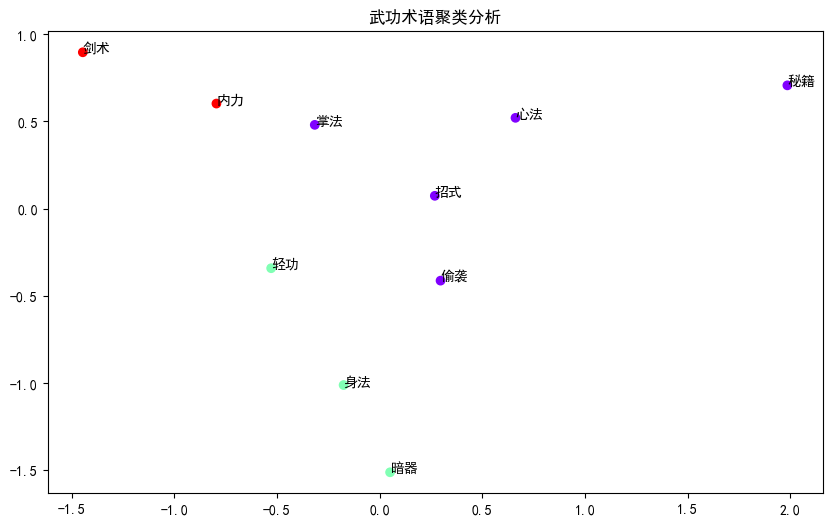

In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 选取武功类词语
martial_terms = ['剑术', '掌法', '内力', '轻功', '身法', 
                '暗器', '偷袭', '招式', '心法', '秘籍']

# 获取词向量
term_vectors = [model.wv[term] for term in martial_terms]

# K-means聚类
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(term_vectors)

# 可视化（PCA降维）
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(term_vectors)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题
plt.figure(figsize=(10, 6))
plt.scatter(vectors_2d[:,0], vectors_2d[:,1], c=clusters, cmap='rainbow')
for i, term in enumerate(martial_terms):
    plt.annotate(term, xy=(vectors_2d[i,0], vectors_2d[i,1]))
plt.title("武功术语聚类分析")
plt.show()

In [47]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_paragraph_vector(paragraph):
    vectors = [model.wv[word] for word in paragraph if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 示例段落
para1 = process_text("只见那黑衣人长剑一抖，使出一招天外飞仙，剑光如电般直取对方咽喉")
para2 = process_text("青衫客反手拔出腰间单刀，使出一式力劈华山，刀风呼啸气势惊人")
para3 = process_text("客栈里的小二端着茶盘，小心翼翼地给客人斟上热茶")

# 计算段落向量
vec1 = get_paragraph_vector(para1).reshape(1, -1)
vec2 = get_paragraph_vector(para2).reshape(1, -1)
vec3 = get_paragraph_vector(para3).reshape(1, -1)
vectors = np.vstack([vec1, vec2, vec3])

# 相似度矩阵
similarities = cosine_similarity(vectors)
print("\n段落相似度矩阵：")
print("武打段落1 vs 武打段落2:", similarities[0,1])
print("武打段落1 vs 日常段落3:", similarities[0,2])


段落相似度矩阵：
武打段落1 vs 武打段落2: 0.93569803
武打段落1 vs 日常段落3: 0.72989523
